# Problemin Tanımı:

> Doktor ortamında paylaşılan problemden sonra çekilen
filmde doktora ulaşmadan hemen önce x-ray üzerinde kırığın hemen tespit
edilmesi.

# Veri Hakkında:

> Veri seti içerisinde 38 adet kırık kol x-ray görüntüleri jpg ve jpeg formatında bulunmaktadır. Veri setine ek olarak yapılan işaretlemelerle birlikte kırık kemiklerin işaretlendiği json dosyaları eklenmiştir.

# Görüntü işleme yöntemlerinin uygulaması

### Kütüphanelerin eklenmesi

In [7]:
import cv2
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy
from skimage.util import view_as_windows

### Görselin eklenmesi

In [8]:
image_path='DB/img1.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV renk düzeni BGR, matplotlib RGB kullanır
image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Aldığımız sonuçlara göre seçtiğimiz görüntü işleme yöntemi

##### İlk üç görsele Gamma + STD + Eşikleme + Medyan + Min-Max Normalizasyonu uygulama örneği

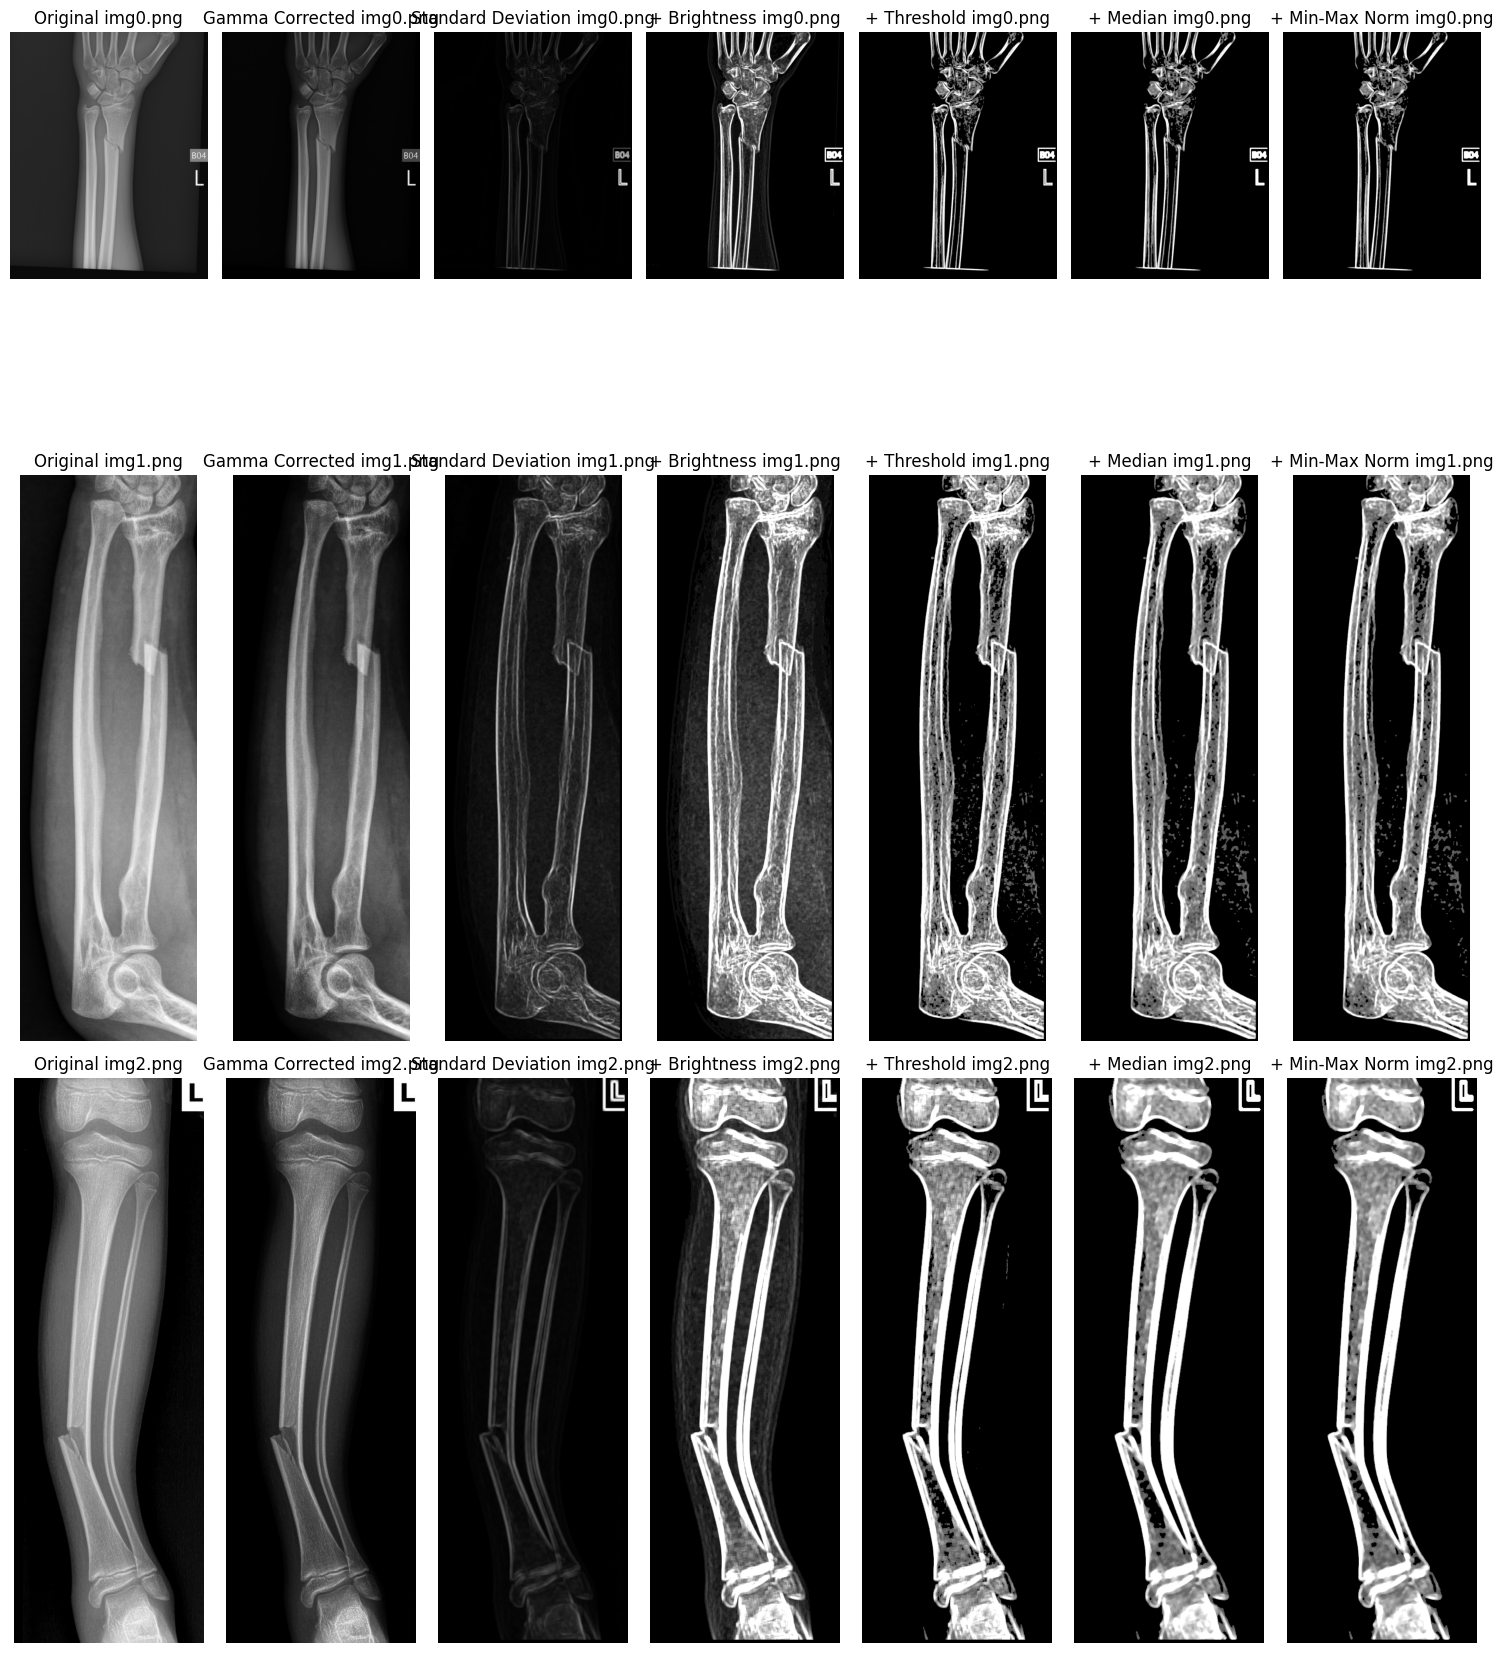

In [9]:
# Görseli işleyen fonksiyon
def process_image(image_path):
    # Görseli oku (OpenCV ile)
    image = cv2.imread(image_path)  # Görseli oku (OpenCV ile)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Görseli RGB formatına çevir (OpenCV BGR okur)

    # Gamma düzeltme fonksiyonu
    def gamma_correction(image, gamma):
        img_array = np.asarray(image) / 255.0  # Görseli [0,1] aralığına normalize et
        img_array = np.power(img_array, gamma)  # Gamma fonksiyonunu uygula
        img_array = np.clip(img_array * 255, 0, 255).astype(np.uint8)  # Görseli tekrar [0,255] aralığına döndür
        return img_array

    # Görseli gamma düzeltmesi ile işleyelim (gamma=2.0)
    img_gamma = gamma_correction(image_rgb, 2.0)

    # Renkli görseli gri tonlamaya çevir
    image_gray = cv2.cvtColor(img_gamma, cv2.COLOR_RGB2GRAY)

    # Pencerelerin boyutu (7x7)
    window_size = (7, 7)

    # Gri görseli küçük pencerelere ayır
    windows = view_as_windows(image_gray, window_size)

    # Standard sapma görseli oluşturmak için boş bir dizi
    std_image = np.zeros_like(image_gray, dtype=np.float32)

    # Her pencere için standard sapma hesapla
    for i in range(windows.shape[0]):
        for j in range(windows.shape[1]):
            window = windows[i, j]  # Pencereyi al
            std_value = np.std(window)  # Bu penceredeki standard sapmayı hesapla
            std_image[i, j] = std_value  # Hesaplanan standard sapmayı görsele yaz

    # Standard sapma görselini PIL formatına çevir
    std_image_pil = Image.fromarray(np.uint8(std_image))

    # Parlaklık ayarlama fonksiyonu
    def adjust_brightness(image, factor):
        image_rgb = np.stack([image] * 3, axis=-1)  # Görseli 3 kanallı yap (RGB)
        hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)  # Görseli HSV renk uzayına çevir
        hsv = np.array(hsv, dtype=np.float64)  # HSV değerlerini float64 tipine çevir
        hsv[:,:,2] = np.clip(hsv[:,:,2] * factor, 0, 255)  # Parlaklık kanalını faktörle çarp ve sınırla
        return cv2.cvtColor(np.uint8(hsv), cv2.COLOR_HSV2RGB)  # Görseli tekrar RGB'ye çevir

    # Parlaklık artırma işlemi uygula
    img_bright = adjust_brightness(std_image_pil, 15)

    # Parlaklık eşikleme fonksiyonu
    def threshold_brightness(image, threshold):
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Görseli gri tonlamaya çevir
        _, thresholded_image = cv2.threshold(image_gray, threshold, 255, cv2.THRESH_TOZERO)  # Eşikleme uygula
        return cv2.cvtColor(thresholded_image, cv2.COLOR_GRAY2RGB)  # Sonucu tekrar RGB'ye çevir

    # Eşikleme işlemi uygula (parlaklık 75'ın üstündeki pikselleri tut)
    img_bright_thresholded = threshold_brightness(img_bright, 75)

    # Görseli medyan bulanıklaştırma işlemi uygula
    img_bright_thresholded_blurred = cv2.medianBlur(img_bright_thresholded, 5)

    # Min-max normalizasyonu ile görseli yeniden ölçeklendir
    min_max_norm = cv2.normalize(img_bright_thresholded_blurred, None, 0, 255, cv2.NORM_MINMAX)

    return image_rgb, img_gamma, std_image, img_bright, img_bright_thresholded, img_bright_thresholded_blurred, min_max_norm

# Görsel dizini ve dosya isimleri
image_directory = 'DB/'
image_files = [f'img{i}.png' for i in range(3)]  # img0.png'dan img9.png'ye kadar olan dosya isimlerini oluştur

# Görselleri işleyip çıktıları sakla
fig, axes = plt.subplots(len(image_files), 7, figsize=(15, 6 * len(image_files)))

for idx, img_file in enumerate(image_files):
    image_path = image_directory + img_file
    img_rgb, img_gamma, std_img, img_bright, img_bright_thresholded, img_bright_thresholded_blurred, min_max_norm = process_image(image_path)

    # Orijinal renkli görsel
    axes[idx, 0].imshow(img_rgb)
    axes[idx, 0].set_title(f'Original {img_file}')
    axes[idx, 0].axis('off')

    # Gamma düzeltmesi uygulanmış görsel
    axes[idx, 1].imshow(img_gamma)
    axes[idx, 1].set_title(f'Gamma Corrected {img_file}')
    axes[idx, 1].axis('off')

    # Standard sapma görseli
    axes[idx, 2].imshow(std_img, cmap='gray')
    axes[idx, 2].set_title(f'Standard Deviation {img_file}')
    axes[idx, 2].axis('off')

    # STD + Parlaklık görseli
    axes[idx, 3].imshow(img_bright)
    axes[idx, 3].set_title(f'+ Brightness {img_file}')
    axes[idx, 3].axis('off')

    # STD + Parlaklık + Eşikleme görseli
    axes[idx, 4].imshow(img_bright_thresholded)
    axes[idx, 4].set_title(f'+ Threshold {img_file}')
    axes[idx, 4].axis('off')

    # STD + Parlaklık + Eşikleme + Bulanıklaştırma görseli
    axes[idx, 5].imshow(img_bright_thresholded_blurred)
    axes[idx, 5].set_title(f'+ Median {img_file}')
    axes[idx, 5].axis('off')

    # STD + Parlaklık + Eşikleme + Bulanıklaştırma + Normalizasyon görseli
    axes[idx, 6].imshow(min_max_norm)
    axes[idx, 6].set_title(f'+ Min-Max Norm {img_file}')
    axes[idx, 6].axis('off')

# Görselleri düzgün bir şekilde yerleştir
plt.tight_layout()
plt.show()


## Görüntü işleme yöntemleri

### Yumuşatma

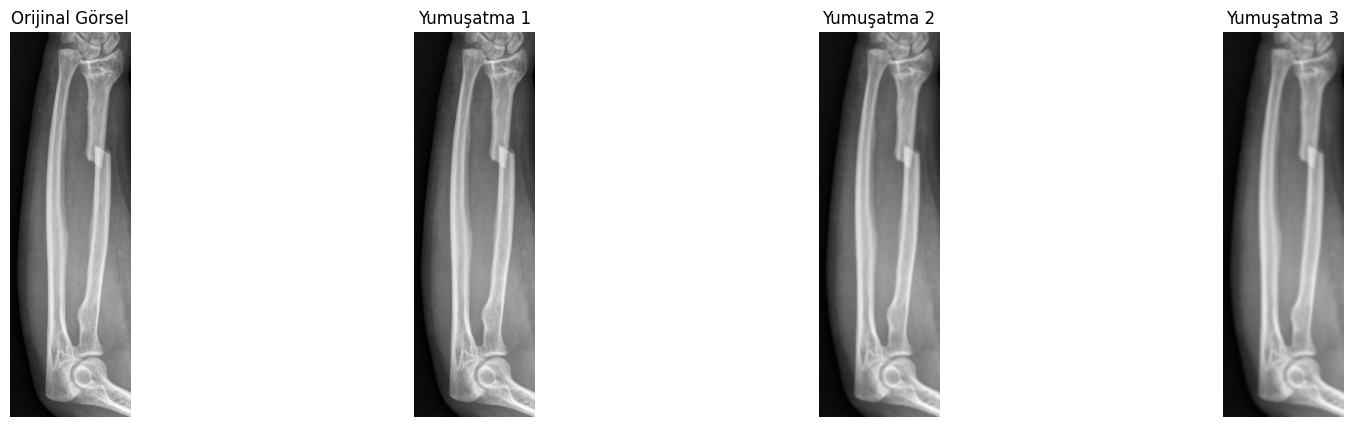

In [10]:
blurred_images = [
    cv2.GaussianBlur(image_rgb, (5, 5), 0),  # Küçük blur
    cv2.GaussianBlur(image_rgb, (15, 15), 0), # Orta büyüklükte blur
    cv2.GaussianBlur(image_rgb, (25, 25), 0)  # Büyük blur
]

# Görselleri yan yana koy
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Orijinal görsel
axes[0].imshow(image_rgb)
axes[0].set_title('Orijinal Görsel')
axes[0].axis('off')

# Yumuşatılmış görseller
for i, blurred_image in enumerate(blurred_images):
    axes[i + 1].imshow(blurred_image)
    axes[i + 1].set_title(f'Yumuşatma {i + 1}')
    axes[i + 1].axis('off')

plt.show()

### Keskinleştirme

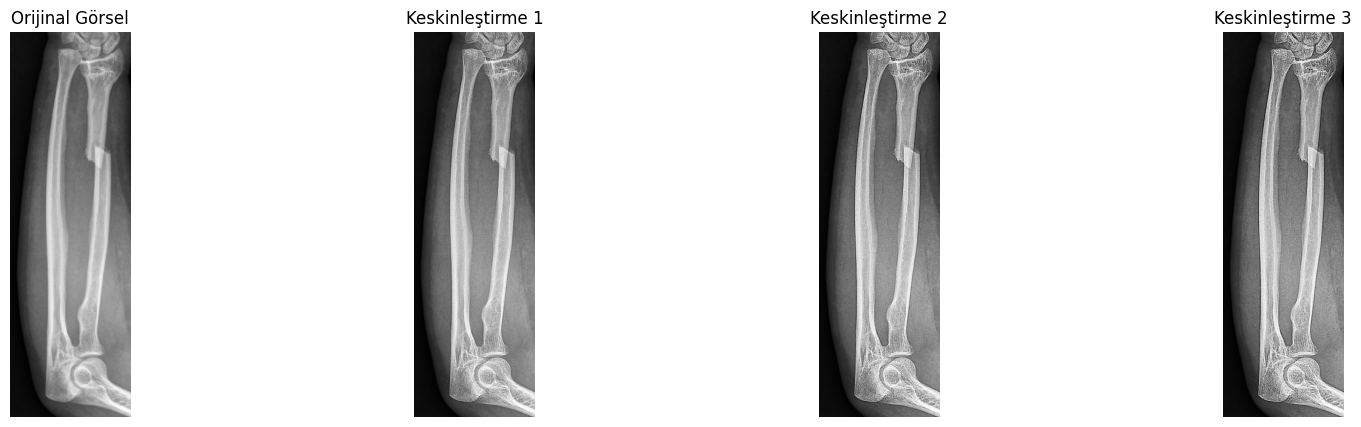

In [11]:
# Görseli PIL formatına dönüştür (UnsharpMask ile filtre uygulamak için)
original_img = Image.fromarray(image_rgb)

# Keskinleştirme filtrelerini uygula (daha yüksek percent değerleri ile)
sharpened_img_1 = original_img.filter(ImageFilter.UnsharpMask(radius=2, percent=300, threshold=5))
sharpened_img_2 = original_img.filter(ImageFilter.UnsharpMask(radius=2, percent=500, threshold=5))
sharpened_img_3 = original_img.filter(ImageFilter.UnsharpMask(radius=2, percent=700, threshold=5))

# Sonuçları görselleştirmek için matplotlib ile göster
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Görselleri RGB formatında düzgün bir şekilde göster
axes[0].imshow(image_rgb)
axes[0].set_title("Orijinal Görsel")
axes[0].axis('off')

axes[1].imshow(np.array(sharpened_img_1))
axes[1].set_title("Keskinleştirme 1")
axes[1].axis('off')

axes[2].imshow(np.array(sharpened_img_2))
axes[2].set_title("Keskinleştirme 2")
axes[2].axis('off')

axes[3].imshow(np.array(sharpened_img_3))
axes[3].set_title("Keskinleştirme 3")
axes[3].axis('off')

plt.show()


### Mean(ortalama)

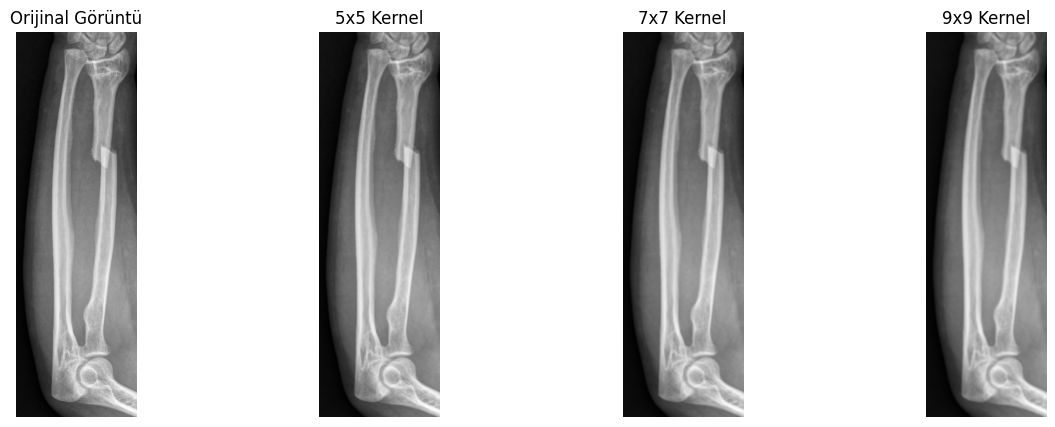

In [12]:
kernel_sizes = [5, 7, 9]
mean_filtered_images = []

for size in kernel_sizes:
    # Ortalama filtre uygula
    filtered_image = cv2.blur(image_rgb, (size, size))
    mean_filtered_images.append(filtered_image)

# Görüntüleri yan yana gösterme
plt.figure(figsize=(15, 5))

# Orijinal görüntü
plt.subplot(1, 4, 1)
plt.imshow(image_rgb)
plt.title('Orijinal Görüntü')
plt.axis('off')

# Farklı kernel boyutları ile filtrelenmiş görüntüler
for i, size in enumerate(kernel_sizes):
    plt.subplot(1, 4, i+2)
    plt.imshow(mean_filtered_images[i])
    plt.title(f'{size}x{size} Kernel')
    plt.axis('off')

# Görüntüleri göster
plt.show()

### Median

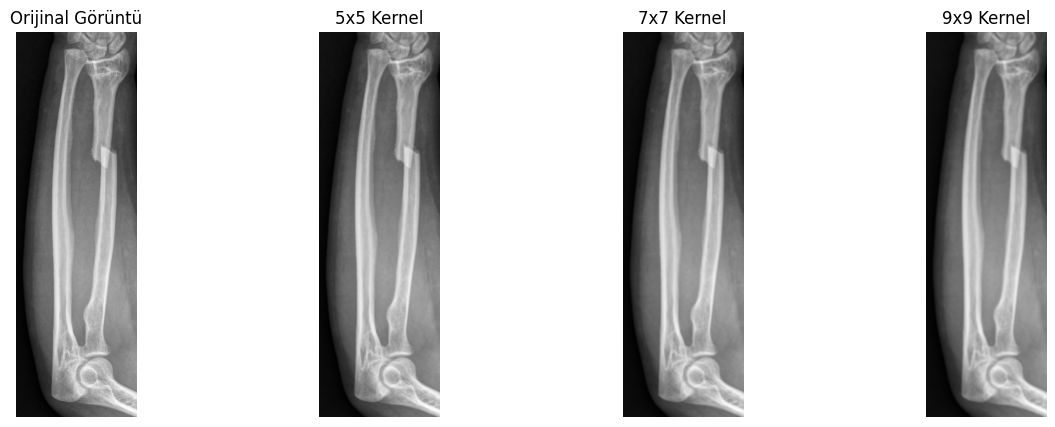

In [13]:
kernel_sizes = [5, 7, 9]
mean_filtered_images = []

for size in kernel_sizes:
    # Ortalama filtre uygula
    filtered_image = cv2.blur(image_rgb, (size, size))
    mean_filtered_images.append(filtered_image)

# Görüntüleri yan yana gösterme
plt.figure(figsize=(15, 5))

# Orijinal görüntü
plt.subplot(1, 4, 1)
plt.imshow(image_rgb)
plt.title('Orijinal Görüntü')
plt.axis('off')

# Farklı kernel boyutları ile filtrelenmiş görüntüler
for i, size in enumerate(kernel_sizes):
    plt.subplot(1, 4, i+2)
    plt.imshow(mean_filtered_images[i])
    plt.title(f'{size}x{size} Kernel')
    plt.axis('off')

# Görüntüleri göster
plt.show()


### AdaptifMed

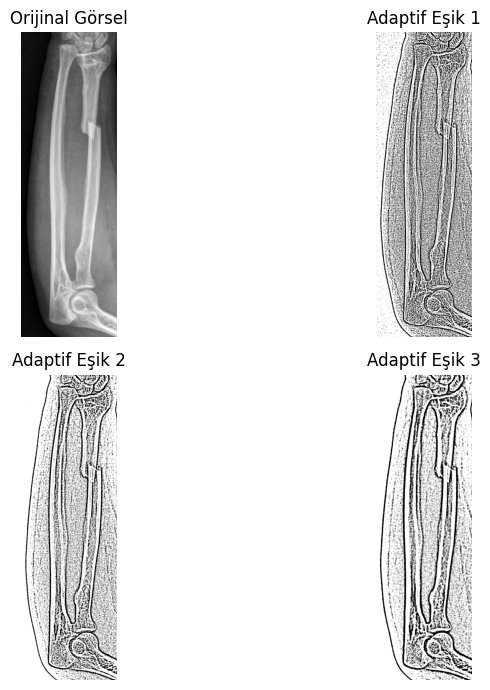

In [14]:
# 3 farklı adaptif eşikleme değeri ile işlemler
threshold1 = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
threshold2 = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 4)
threshold3 = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

# Sonuçları görselleştir
plt.figure(figsize=(10, 7))

# Orijinal görsel
plt.subplot(2, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Orijinal Görsel')
plt.axis('off')

# İlk adaptif eşikleme
plt.subplot(2, 2, 2)
plt.imshow(threshold1, cmap='gray')
plt.title('Adaptif Eşik 1')
plt.axis('off')

# İkinci adaptif eşikleme
plt.subplot(2, 2, 3)
plt.imshow(threshold2, cmap='gray')
plt.title('Adaptif Eşik 2')
plt.axis('off')

# Üçüncü adaptif eşikleme
plt.subplot(2, 2, 4)
plt.imshow(threshold3, cmap='gray')
plt.title('Adaptif Eşik 3')
plt.axis('off')

plt.tight_layout()
plt.show()

### Normalizasyon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7469177883151037..2.2196769132109093].


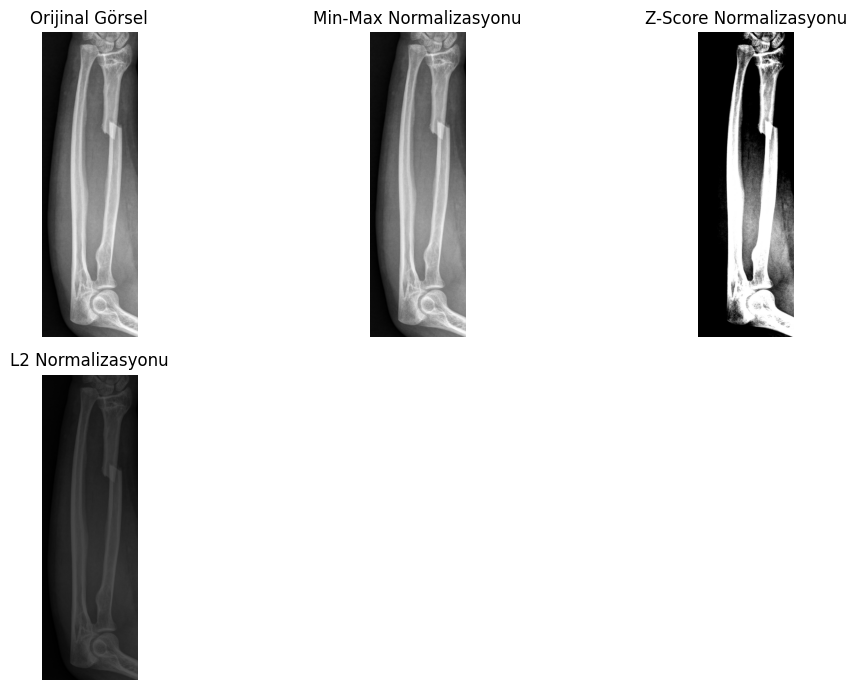

In [15]:
# Normalizasyon için 3 farklı yöntem

# 1. Min-Max Normalizasyonu (0 ile 255 arasında normalize et)
min_max_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

# 2. Z-Score Normalizasyonu (Ortalamadan çıkarıp standart sapmaya bölme)
mean = np.mean(image)
std_dev = np.std(image)
# std_dev sıfır olursa, normalizasyon yapılmaz.
if std_dev > 0:
    z_score_norm = (image - mean) / std_dev
else:
    z_score_norm = np.zeros_like(image)

# 3. L2 Normalizasyonu (Her pikselin L2 normunu alarak normalize et)
l2_norm = np.linalg.norm(image)
if l2_norm > 0:
    l2_norm_img = image / l2_norm * 255
else:
    l2_norm_img = np.zeros_like(image)

# Görselleri çizme
plt.figure(figsize=(10, 7))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Orijinal Görsel')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(min_max_norm, cmap='gray')
plt.title('Min-Max Normalizasyonu')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(z_score_norm, cmap='gray')
plt.title('Z-Score Normalizasyonu')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(l2_norm_img, cmap='gray')
plt.title('L2 Normalizasyonu')
plt.axis('off')

plt.tight_layout()
plt.show()


### Parlaklık

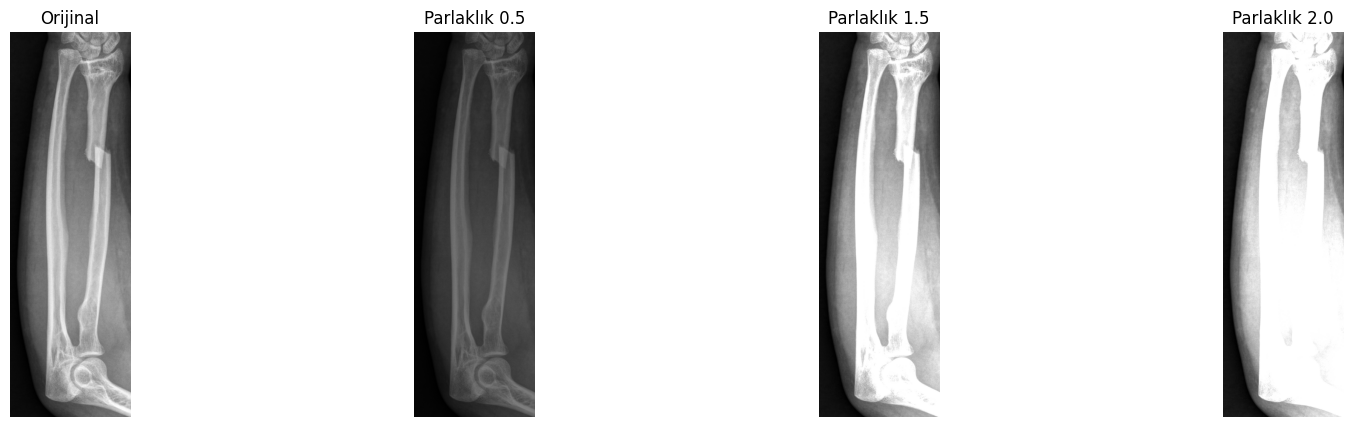

In [16]:
# Parlaklık artırma fonksiyonu
def adjust_brightness(image, factor):
    # Parlaklık artırma: faktör > 1, parlaklık artar; faktör < 1, parlaklık azalır
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)  # HSV renk uzayına dönüştür
    hsv = np.array(hsv, dtype=np.float64)  # Görseli float64 formatına dönüştür
    hsv[:,:,2] = hsv[:,:,2] * factor  # V (value) kanalındaki parlaklık değerini artır
    hsv[:,:,2] = np.clip(hsv[:,:,2], 0, 255)  # Parlaklık değerlerini sınırla
    return cv2.cvtColor(np.uint8(hsv), cv2.COLOR_HSV2RGB)  # HSV'yi tekrar RGB'ye çevir

# 3 farklı parlaklık değerini uygula
img_bright_1 = adjust_brightness(image_rgb, 0.5)  # Parlaklık değeri < 1, koyulaşır
img_bright_2 = adjust_brightness(image_rgb, 1.5)  # Parlaklık değeri > 1, parlaklaşır
img_bright_3 = adjust_brightness(image_rgb, 2.0)  # Parlaklık değeri > 1, daha da parlak

# Görselleri yan yana göstermek için matplotlib kullan
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Görselleri alt alta koy
axs[0].imshow(image_rgb)
axs[0].set_title('Orijinal')
axs[0].axis('off')

axs[1].imshow(img_bright_1)
axs[1].set_title('Parlaklık 0.5')
axs[1].axis('off')

axs[2].imshow(img_bright_2)
axs[2].set_title('Parlaklık 1.5')
axs[2].axis('off')

axs[3].imshow(img_bright_3)
axs[3].set_title('Parlaklık 2.0')
axs[3].axis('off')

plt.show()

### Zıtlık

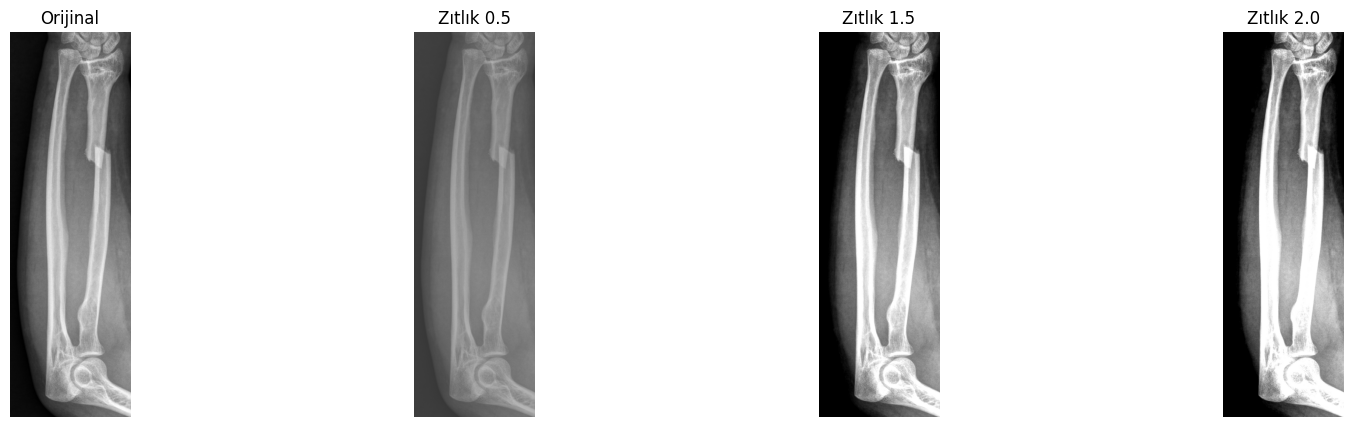

In [17]:
# Görseli Pillow ile işlemek için RGB formatına dönüştür
img = Image.fromarray(image_rgb)

# Zıtlık artırıcıyı oluştur
enhancer1 = ImageEnhance.Contrast(img)
enhancer2 = ImageEnhance.Contrast(img)
enhancer3 = ImageEnhance.Contrast(img)

# 3 farklı zıtlık değerini uygula
img_contrast_1 = enhancer1.enhance(0.5)  # Zıtlık değeri < 1, zıtlık azalır
img_contrast_2 = enhancer2.enhance(1.5)  # Zıtlık değeri > 1, zıtlık artar
img_contrast_3 = enhancer3.enhance(2.0)  # Zıtlık değeri > 1, daha da artar

# Görselleri yan yana göstermek için matplotlib kullan
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Görselleri alt alta koy
axs[0].imshow(img)
axs[0].set_title('Orijinal')
axs[0].axis('off')

axs[1].imshow(img_contrast_1)
axs[1].set_title('Zıtlık 0.5')
axs[1].axis('off')

axs[2].imshow(img_contrast_2)
axs[2].set_title('Zıtlık 1.5')
axs[2].axis('off')

axs[3].imshow(img_contrast_3)
axs[3].set_title('Zıtlık 2.0')
axs[3].axis('off')

plt.show()

### Gamma

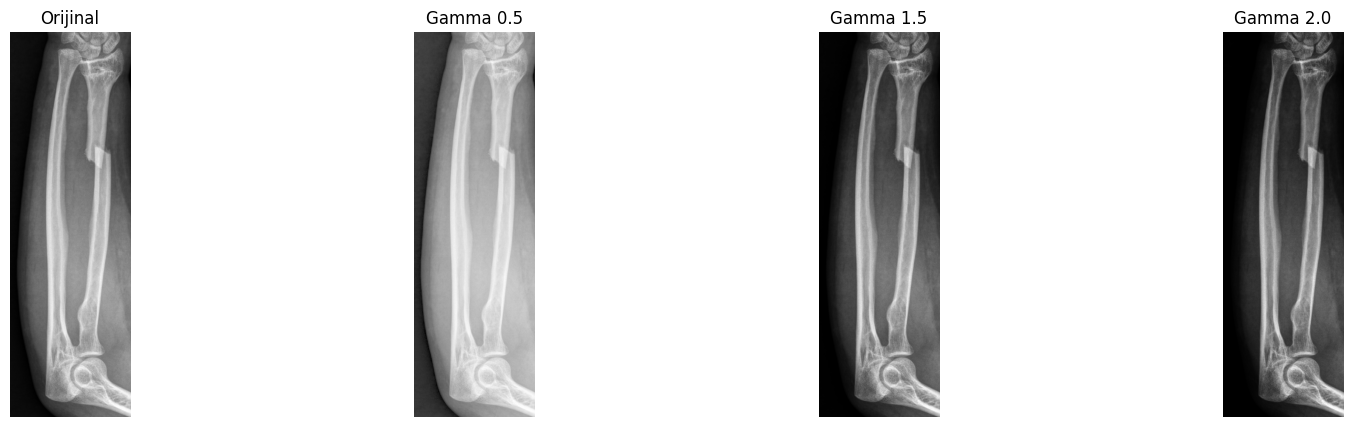

In [18]:
def gamma_correction(image, gamma):
    # Görseli numpy array'ine dönüştür
    img_array = np.asarray(image) / 255.0  # Piksel değerlerini 0-1 aralığına çek
    # Gamma düzeltmesini uygula
    img_array = np.power(img_array, gamma)  # Piksel değerlerini gamma ile yükselt
    img_array = np.clip(img_array * 255, 0, 255).astype(np.uint8)  # 0-255 aralığına geri getir
    return img_array

# 3 farklı gamma değerini uygula
img_gamma_1 = gamma_correction(image_rgb, 0.5)  # Gamma < 1, daha parlak
img_gamma_2 = gamma_correction(image_rgb, 1.5)  # Gamma > 1, daha koyu
img_gamma_3 = gamma_correction(image_rgb, 2.0)  # Daha büyük gamma, çok daha koyu

# Görselleri yan yana göstermek için matplotlib kullan
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Görselleri alt alta koy
axs[0].imshow(image_rgb)
axs[0].set_title('Orijinal')
axs[0].axis('off')

axs[1].imshow(img_gamma_1)
axs[1].set_title('Gamma 0.5')
axs[1].axis('off')

axs[2].imshow(img_gamma_2)
axs[2].set_title('Gamma 1.5')
axs[2].axis('off')

axs[3].imshow(img_gamma_3)
axs[3].set_title('Gamma 2.0')
axs[3].axis('off')

plt.show()

### Histogram eşitleme 

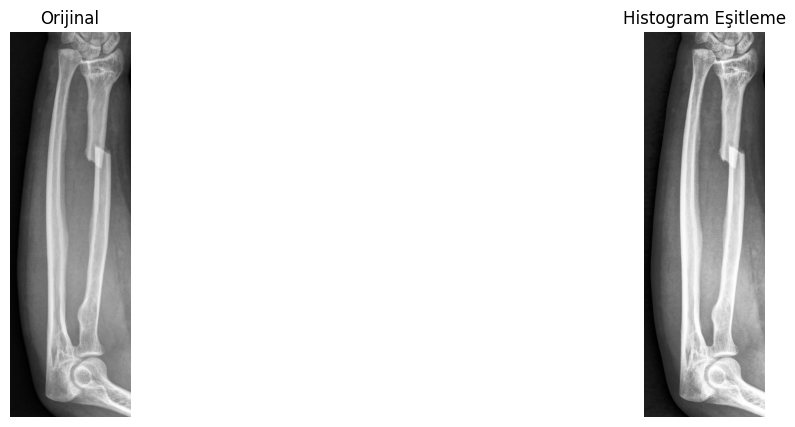

In [19]:
def histogram_equalization(image):
    # Gri tonlamalı görsel üzerinde histogram eşitleme uygula
    img_eq = cv2.equalizeHist(image)
    # Eşitlenmiş görseli RGB'ye tekrar dönüştür
    img_eq_rgb = cv2.cvtColor(img_eq, cv2.COLOR_GRAY2RGB)
    return img_eq_rgb

# Histogram eşitleme uygulandıktan sonra görseli elde et
img_eq = histogram_equalization(image_gray)

# Görselleri yan yana göstermek için matplotlib kullan
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Görselleri alt alta koy
axs[0].imshow(image_rgb)
axs[0].set_title('Orijinal')
axs[0].axis('off')

axs[1].imshow(img_eq)
axs[1].set_title('Histogram Eşitleme')
axs[1].axis('off')

plt.show()

### Sobel

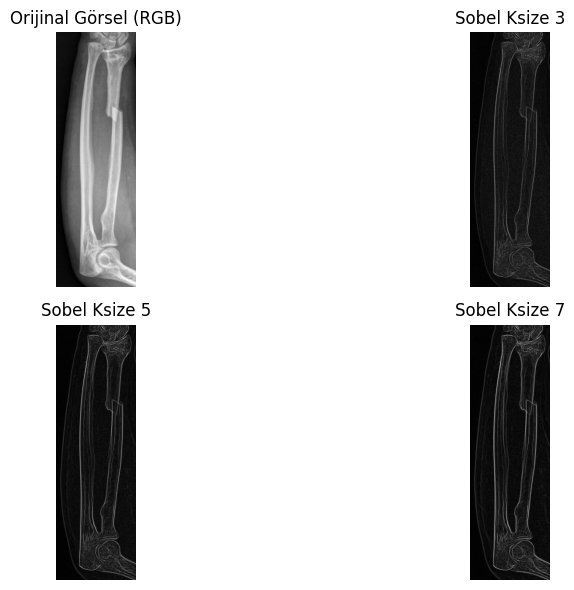

In [20]:
# Sobel filtre değerleri
ksize_values = [3, 5, 7]  # Farklı kernel boyutları

# Sonuçları tutmak için bir liste
sobel_results = []

# Her bir kernel boyutunda Sobel filtresi uygula
for ksize in ksize_values:
    # Sobel filtrelerini x ve y yönlerinde uygula
    sobel_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=ksize)
    
    # X ve Y yönündeki kenarları birleştir
    sobel_edges = cv2.magnitude(sobel_x, sobel_y)
    sobel_results.append(sobel_edges)

# Görseli ve Sobel filtrelerini çiz
plt.figure(figsize=(12, 6))

# Orijinal renkli görseli ekle
plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('Orijinal Görsel (RGB)')
plt.axis('off')

# Sobel filtreli görselleri ekle
for i, sobel_edges in enumerate(sobel_results):
    plt.subplot(2, 2, i + 2)
    plt.imshow(sobel_edges, cmap='gray')
    plt.title(f'Sobel Ksize {ksize_values[i]}')
    plt.axis('off')

# Çıktıları göster
plt.tight_layout()
plt.show()

### Canny

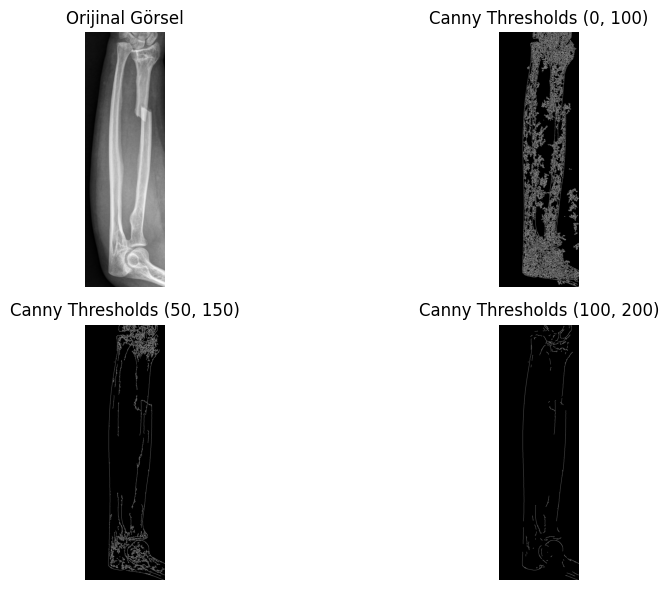

In [21]:
# Canny filtre parametreleri için alt ve üst eşik değerleri
thresholds = [(0, 100), (50, 150), (100, 200)]  # Farklı eşik değerleri

# Sonuçları tutmak için bir liste
canny_results = []

# Her bir eşik değeri çifti ile Canny filtresi uygula
for lower, upper in thresholds:
    # Canny kenar algılama
    canny_edges = cv2.Canny(image_gray, lower, upper)
    canny_results.append(canny_edges)

# Görseli ve Canny filtrelerini çiz
plt.figure(figsize=(12, 6))

# Orijinal RGB görseli ekle
plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('Orijinal Görsel')
plt.axis('off')

# Canny filtreli görselleri ekle
for i, canny_edges in enumerate(canny_results):
    plt.subplot(2, 2, i + 2)
    plt.imshow(canny_edges, cmap='gray')
    plt.title(f'Canny Thresholds {thresholds[i]}')
    plt.axis('off')

# Çıktıları göster
plt.tight_layout()
plt.show()


### Laplacian

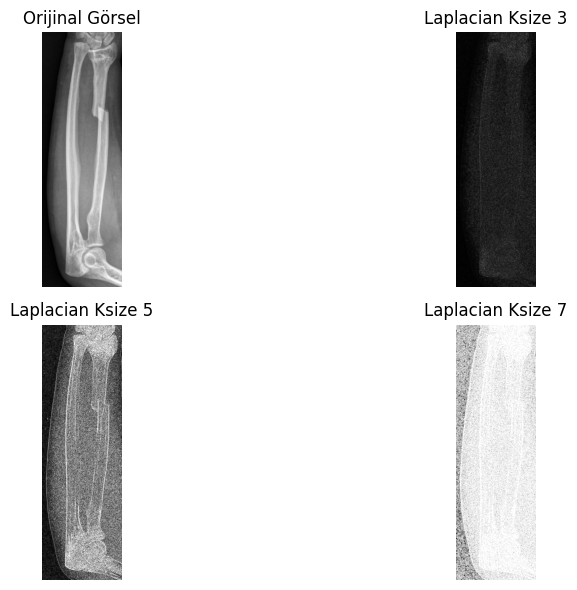

In [22]:
# Laplacian filtresi için kernel boyutları
ksize_values = [3, 5, 7]  # Farklı kernel boyutları

# Sonuçları tutmak için bir liste
laplacian_results = []

# Her bir kernel boyutunda Laplacian filtresi uygula
for ksize in ksize_values:
    # Laplacian filtresi uygula
    laplacian_edges = cv2.Laplacian(image_gray, cv2.CV_64F, ksize=ksize)
    laplacian_edges = cv2.convertScaleAbs(laplacian_edges)  # Pozitif değerlere çevir
    laplacian_results.append(laplacian_edges)

# Görseli ve Laplacian filtrelerini çiz
plt.figure(figsize=(12, 6))

# Orijinal görseli RGB formatında ekle
plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('Orijinal Görsel')
plt.axis('off')

# Laplacian filtreli görselleri ekle
for i, laplacian_edges in enumerate(laplacian_results):
    plt.subplot(2, 2, i + 2)
    plt.imshow(laplacian_edges, cmap='gray')
    plt.title(f'Laplacian Ksize {ksize_values[i]}')
    plt.axis('off')

# Çıktıları göster
plt.tight_layout()
plt.show()

### Entropi

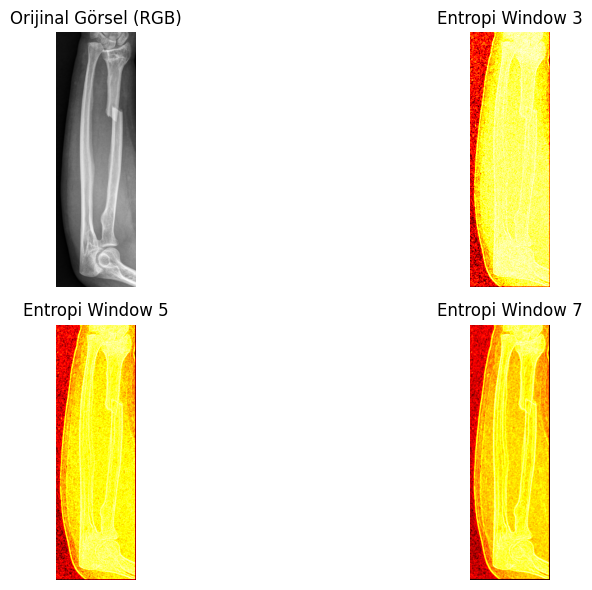

In [23]:
# Entropi hesaplamak için pencere boyutları
window_sizes = [3, 5, 7]  # Farklı pencere boyutları

# Sonuçları tutmak için bir liste
entropy_results = []

# Her bir pencere boyutunda Entropi filtresi uygula
for size in window_sizes:
    # Görseli pencerelere ayır
    windows = view_as_windows(image_gray, (size, size))
    
    # Entropi hesapla her pencere için
    entropy_image = np.zeros_like(image_gray, dtype=np.float32)
    for i in range(windows.shape[0]):
        for j in range(windows.shape[1]):
            entropy_image[i, j] = shannon_entropy(windows[i, j])
    
    # Sonuçları kaydet
    entropy_results.append(entropy_image)

# Görseli ve Entropi filtrelerini çiz
plt.figure(figsize=(12, 6))

# Orijinal görseli ekle
plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('Orijinal Görsel (RGB)')
plt.axis('off')

# Entropi filtreli görselleri ekle
for i, entropy_image in enumerate(entropy_results):
    plt.subplot(2, 2, i + 2)
    plt.imshow(entropy_image, cmap='hot')
    plt.title(f'Entropi Window {window_sizes[i]}')
    plt.axis('off')

# Çıktıları göster
plt.tight_layout()
plt.show()

### Range

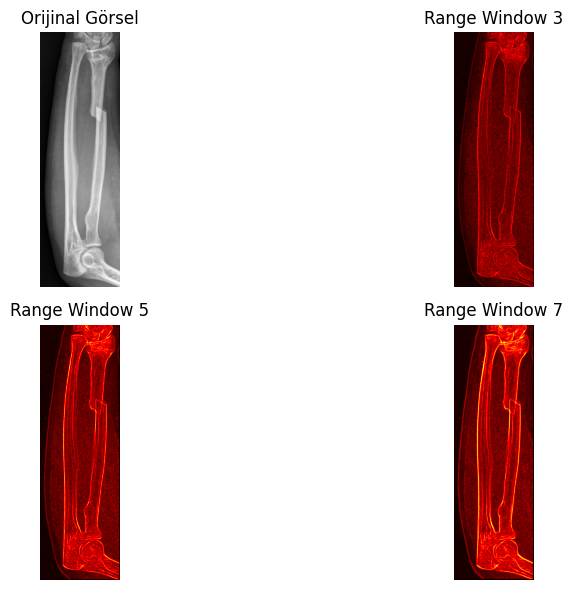

In [24]:
# Range filtresi için pencere boyutları
window_sizes = [3, 5, 7]  # Farklı pencere boyutları

# Sonuçları tutmak için bir liste
range_results = []

# Her bir pencere boyutunda Range filtresi uygula
for size in window_sizes:
    # Görseli pencerelere ayır
    windows = view_as_windows(image_gray, (size, size))
    
    # Range hesapla her pencere için
    range_image = np.zeros_like(image_gray, dtype=np.float32)
    for i in range(windows.shape[0]):
        for j in range(windows.shape[1]):
            window = windows[i, j]
            # Pencerenin maksimum ve minimum değerlerini al
            range_value = np.max(window) - np.min(window)
            range_image[i, j] = range_value
    
    # Sonuçları kaydet
    range_results.append(range_image)

# Görseli ve Range filtrelerini çiz
plt.figure(figsize=(12, 6))

# Orijinal görseli ekle
plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('Orijinal Görsel')
plt.axis('off')

# Range filtreli görselleri ekle
for i, range_image in enumerate(range_results):
    plt.subplot(2, 2, i + 2)
    plt.imshow(range_image, cmap='hot')
    plt.title(f'Range Window {window_sizes[i]}')
    plt.axis('off')

# Çıktıları göster
plt.tight_layout()
plt.show()

### STD

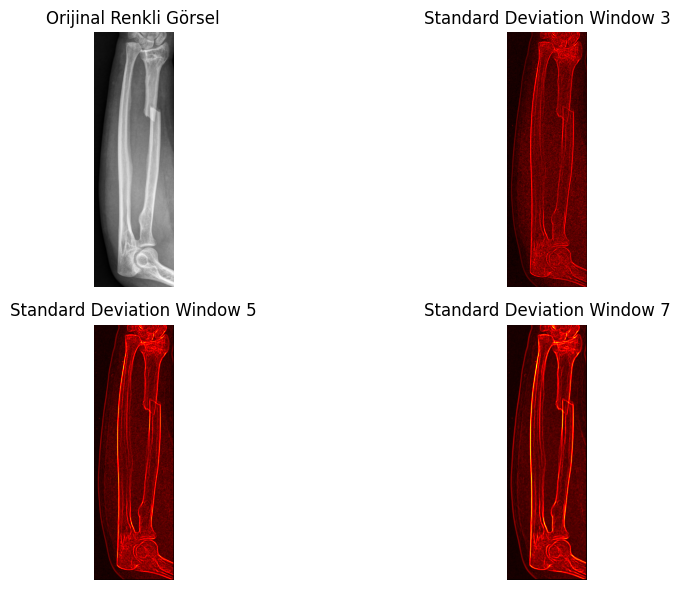

In [25]:
# Standart sapma filtresi için pencere boyutları
window_sizes = [3, 5, 7]  # Farklı pencere boyutları

# Sonuçları tutmak için bir liste
std_results = []

# Her bir pencere boyutunda Std filtresi uygula
for size in window_sizes:
    # Görseli pencerelere ayır
    windows = view_as_windows(image_gray, (size, size))
    
    # Standart sapma hesapla her pencere için
    std_image = np.zeros_like(image_gray, dtype=np.float32)
    for i in range(windows.shape[0]):
        for j in range(windows.shape[1]):
            window = windows[i, j]
            # Pencerenin standart sapmasını hesapla
            std_value = np.std(window)
            std_image[i, j] = std_value
    
    # Sonuçları kaydet
    std_results.append(std_image)

# Görseli ve Std filtrelerini çiz
plt.figure(figsize=(12, 6))

# Orijinal renkli görseli ekle
plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('Orijinal Renkli Görsel')
plt.axis('off')

# Std filtreli görselleri ekle
for i, std_image in enumerate(std_results):
    plt.subplot(2, 2, i + 2)
    plt.imshow(std_image, cmap='hot')
    plt.title(f'Standard Deviation Window {window_sizes[i]}')
    plt.axis('off')

# Çıktıları göster
plt.tight_layout()
plt.show()